In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
#!pip install dask[dataframe]
#!pip install pandas --upgrade
# We have to do this as dask is bad at guessing the types of objects for some reason
# Also, if you are having trouble with running the dataframe and continuously get 
# Fatal Python error: GC object already tracked, try to update pandas
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv')
data_subset = df.head(1000)


In [59]:
# Clean geolocation data if need be. Doesn't look like we have to, though
from geopy.geocoders import Nominatim
# Need to install geopy
#!pip install geopy
geolocator = Nominatim()
location = geolocator.geocode(data_subset['Block'][0])
# print location.latitude, location.longitude
# print data_subset['Latitude'][0], data_subset['Longitude'][0]


In [19]:
# Clean the data
# If we want to be able to coun the number of arrests, then convert it to integers
# I suppose when the officer doesn't record the x coordinate, it becomes a zero for some reason.
# Remove those as well
df['int_Arrest'] = df['Arrest'].astype(int)
df['int_Domestic'] = df['Domestic'].astype(int)
df = df[df['X Coordinate'] != 0]

0.286631708337


In [3]:
import numpy as np
from bokeh.plotting import figure, output_notebook, show
output_notebook()

def histogram(x,colors=None):
    hist,edges = np.histogram(x, bins=100)
    p = figure(y_axis_label="Pixels",
               tools='', height=130, outline_line_color=None,
               min_border=0, min_border_left=0, min_border_right=0,
               min_border_top=0, min_border_bottom=0)
    p.quad(top=hist[1:], bottom=0, left=edges[1:-1], right=edges[2:])
    print("min: {}, max: {}".format(np.min(x),np.max(x)))
    show(p)

Loading BokehJS ...

In [18]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

x_range=(-91.686565684,-87.524529378)
y_range=(36.619446395,42.022910333)

cvs = ds.Canvas(plot_width=800, plot_height=500)
agg = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.mean('int_Arrest'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
histogram(tf.eq_hist(agg.values))

ValueError: range parameter must be finite.

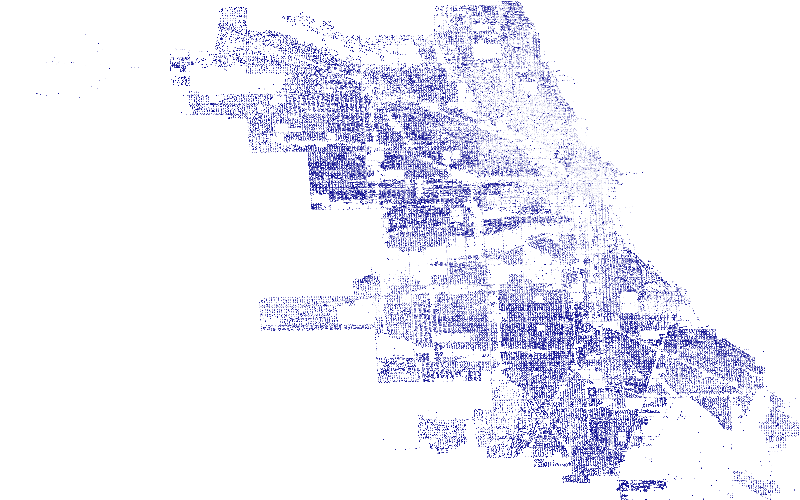

In [15]:
cvs = ds.Canvas(plot_width=800, plot_height=500)
agg = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.mean('int_Domestic'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img